<a href="https://colab.research.google.com/github/jescalada/Tensorflow-colabs/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning: Feature Extraction
We can use a working model's existing architecture and learned patterns.
The model needs to have learned on similar data to our own.

In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [3]:
# Get data (10% of 10 food classes from Food101)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-09-14 00:34:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.207, 74.125.132.207, 74.125.201.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   219MB/s    in 0.7s    

2023-09-14 00:34:26 (219 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [5]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/train'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/stea

In [6]:
# Prepare the data

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# Setting up callbacks
Callbacks are extra functionality you can add to a model to be performed during or after training.  
Some popular ones:
* Tracking experiments with TensorBoard
* Model checkpoints
* Early stopping

In [7]:
# Create a TensorBoard callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d %H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard logfiles to: {log_dir}")
  return tensorboard_callback


# Creating models using TensorFlow Hub


In [8]:
# Compare ResNet and EfficientNet

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [9]:
# Import dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [10]:
def create_model(model_url: str, num_classes: int=10) -> tf.keras.Sequential:
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer should be
      equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download pretrained model and save it as a Keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create the model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [11]:
# Create a ResNet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [13]:
# Compile the ResNet model

resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs=10,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="ResNetV250")])

Saving TensorBoard logfiles to: tensorflow_hub/ResNetV250/20230914 003503
Epoch 1/10
24/24 [==============================] - 39s 1s/step - loss: 1.9163 - accuracy: 0.3533 - val_loss: 1.1652 - val_accuracy: 0.6392
Epoch 2/10
24/24 [==============================] - 11s 481ms/step - loss: 0.8966 - accuracy: 0.7267 - val_loss: 0.8303 - val_accuracy: 0.7320
Epoch 3/10
24/24 [==============================] - 10s 445ms/step - loss: 0.6142 - accuracy: 0.8160 - val_loss: 0.7328 - val_accuracy: 0.7616
Epoch 4/10
24/24 [==============================] - 10s 432ms/step - loss: 0.4764 - accuracy: 0.8787 - val_loss: 0.6878 - val_accuracy: 0.7692
Epoch 5/10
24/24 [==============================] - 10s 427ms/step - loss: 0.3751 - accuracy: 0.9147 - val_loss: 0.6619 - val_accuracy: 0.7812
Epoch 6/10
24/24 [==============================] - 10s 436ms/step - loss: 0.3058 - accuracy: 0.9427 - val_loss: 0.6594 - val_accuracy: 0.7756
Epoch 7/10
24/24 [==============================] - 10s 438ms/step - lo

In [14]:
# Create an EfficientNet model
efficientnet_model = create_model(efficientnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [15]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [16]:
# Compile the EfficientNet model

efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                       epochs=10,
                       steps_per_epoch=len(train_data_10_percent),
                       validation_data=test_data,
                       validation_steps=len(test_data),
                       callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                              experiment_name="EfficientNetB0")])

Saving TensorBoard logfiles to: tensorflow_hub/EfficientNetB0/20230914 003818
Epoch 1/10
24/24 [==============================] - 22s 515ms/step - loss: 1.8115 - accuracy: 0.4667 - val_loss: 1.2789 - val_accuracy: 0.7348
Epoch 2/10
24/24 [==============================] - 10s 413ms/step - loss: 1.0392 - accuracy: 0.7733 - val_loss: 0.8575 - val_accuracy: 0.8188
Epoch 3/10
24/24 [==============================] - 9s 391ms/step - loss: 0.7508 - accuracy: 0.8400 - val_loss: 0.6906 - val_accuracy: 0.8424
Epoch 4/10
24/24 [==============================] - 9s 383ms/step - loss: 0.6007 - accuracy: 0.8720 - val_loss: 0.6013 - val_accuracy: 0.8584
Epoch 5/10
24/24 [==============================] - 10s 409ms/step - loss: 0.5078 - accuracy: 0.8960 - val_loss: 0.5515 - val_accuracy: 0.8644
Epoch 6/10
24/24 [==============================] - 10s 415ms/step - loss: 0.4406 - accuracy: 0.9040 - val_loss: 0.5164 - val_accuracy: 0.8664
Epoch 7/10
24/24 [==============================] - 10s 420ms/step

# Plotting the loss curves

In [17]:
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

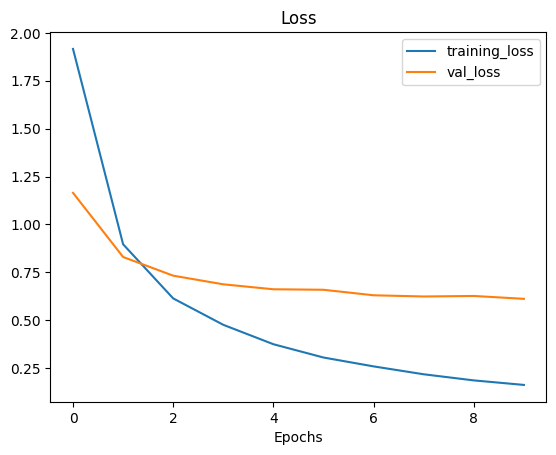

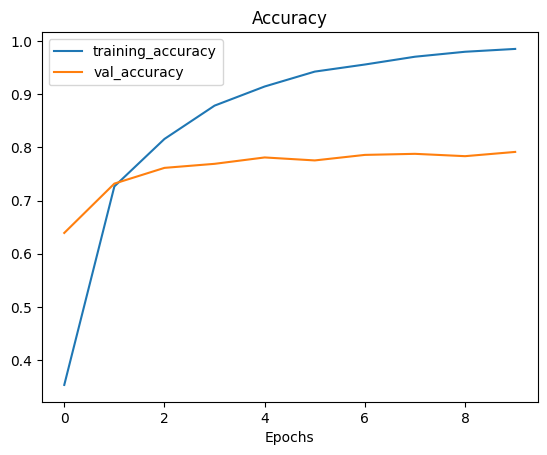

In [18]:
plot_loss_curves(resnet_history)

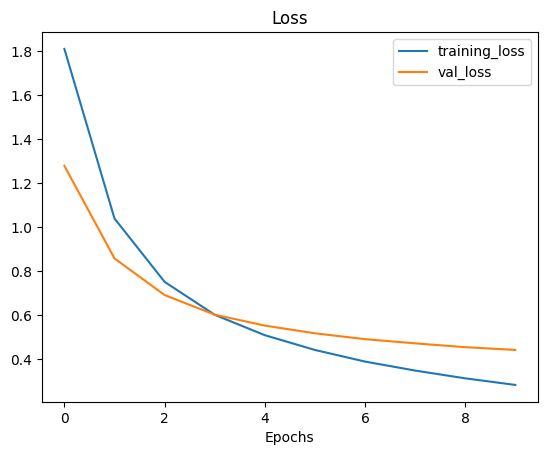

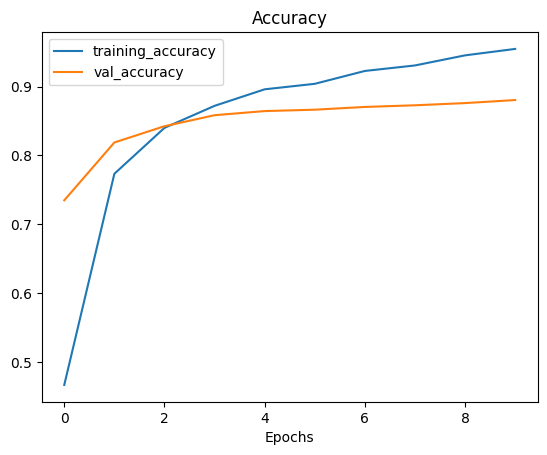

In [19]:
plot_loss_curves(efficientnet_history)

## Types of transfer learning

* **As-is Transfer Learning**: Using an existing model with no changes
* **Feature Extraction Learning**: Using prelearned patterns of another model for your problem
* **Fine Tuning Transfer Learning**: Use prelearned patterns and then fine-tune the underlying layers, including new output layers

## Visualizing with TensorBoard

In [20]:
# Upload TensorBoard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ --name "EfficientNetB0 vs. ResNet50V2" --description "Comparing two different TF Hub feature extraction model architectures" --one_shot


2023-09-14 00:40:29.948204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/05eU3kHYR0qn9CVgbjOILw/

[2023-09-14T00:40:31] Started scanning logdir.
[2023-09-14T00:40:34] Total uploaded: 120 scalars, 0 tensors, 2 binary objects (6.0 MB)
[2023-09-14T00:40:34] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/05eU3kHYR0qn9CVgbjOILw/


In [21]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2023-09-14 00:44:18.924839: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/05eU3kHYR0qn9CVgbjOILw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures
	Id                   05eU3kHYR0qn9CVgbjOILw
	Created              2023-09-14 00:40:31 (3 minutes ago)
	Updated              2023-09-14 00:40:34 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes  6310046
Total: 1 experiment(s)
